# Sentiment Modeling

## Imports

In [1]:
import os
import yaml
import gensim
import builtins
import warnings

warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd 

import seaborn as sns
import matplotlib.pyplot as plt 

from gensim.models import Word2Vec, FastText
from scipy.sparse import save_npz, load_npz

from sklearn.model_selection import train_test_split

import sys
sys.path.append("../")
from src.sentiment_modeling import * 
from src.feature_engineering import *
from src.utility import *
from src.models_and_metrics import MODELS, SCORING_METRICS, CV_STRATEGY, copy_models

## Loading Config

In [2]:
with open("../config.yaml") as f:
    config = yaml.safe_load(f)
    config = config["classical_models"]
fix_config_types(config)
config

{'df_path': 'data/interim/IMDB_feature_engineered.pkl',
 'features': ['cleaned_review_charecter_len',
  'cleaned_review_word_len',
  'positive_tokens_len',
  'negative_tokens_len'],
 'target': 'sentiment',
 'count_vectors_path': 'data/interim/count_vectorized_reviwes.npz',
 'tfidf_vectors_path': 'data/interim/tfidf_vectorized_reviwes.npz',
 'w2v_vectors_path': 'data/interim/w2v_review_vecs.npy',
 'fast_text_vectors_path': 'data/interim/ft_review_vecs.npy',
 'test_size': 0.2,
 'metrics_save_dir': 'results/metrics/',
 'models_save_dir': 'models/',
 'train_without_cv': True,
 'train_with_cv': False,
 'embeddings_to_use': ['numerical_cols']}

In [3]:
def join_paths(d, fn):
    return os.path.join(d,fn)

DF_PATH = join_paths("../", config["df_path"]) #"../data/interim/IMDB_feature_engineered.pkl"
FEATURES = config["features"] #["cleaned_review_charecter_len","cleaned_review_word_len","positive_tokens_len","negative_tokens_len"]
TARGET = config["target"] #"sentiment"

COUNT_VECTORS_PATH = join_paths("../", config["count_vectors_path"]) #"../data/interim/count_vectorized_reviwes.npz"
TFIDF_VECTORS_PATH = join_paths("../", config["tfidf_vectors_path"]) #"../data/interim/tfidf_vectorized_reviwes.npz"
W2V_VECTORS_PATH = join_paths("../", config["w2v_vectors_path"]) #"../data/interim/w2v_review_vecs.npy"
FAST_TEXT_VECTORS_PATH = join_paths("../", config["fast_text_vectors_path"]) #"../data/interim/ft_review_vecs.npy"
TEST_SIZE = config["test_size"] #0.2

METRICS_SAVE_DIR = join_paths("../", config["metrics_save_dir"]) #"../results/metrics/"
MODELS_SAVE_DIR = join_paths("../", config["models_save_dir"]) #"../models/"

TRAIN_WITHOUT_CV = config["train_without_cv"] # True
TRAIN_WITH_CV = config["train_with_cv"] # False

EMBEDDINGS_TO_USE = config["embeddings_to_use"] #["numerical_cols", "count", "tfidf", "w2v", "fast_text"]

## Loading data

In [4]:
if "numerical_cols" in EMBEDDINGS_TO_USE:
    df = load_pickle(DF_PATH).sample(1000)
    df_X = df[FEATURES]
    y = df[TARGET]
    display(df)

,review,sentiment,review_charecters_len,review_word_len,has_html,cleaned_review,tokens,cleaned_review_charecter_len,cleaned_review_word_len,cleaned_review_has_html,positive_tokens,negative_tokens,positive_tokens_len,negative_tokens_len
29403,Why you ask does this man claim to have the tr...,0,3248,775,False,ask man claim truth behind existence almighty ...,"[ask, man, claim, truth, behind, existence, al...",2069,385,False,"[well, wonder, right, right, ready, lead, gold...","[poor, horrendous, doubt, cold, devil, vomit, ...",9,36
866,This show is great for many reasons..The fathe...,1,521,132,False,show great many reasonsthe father mother commu...,"[show, great, many, reasonsthe, father, mother...",364,71,False,"[great, great, great, worth, sexy, best, humor...","[stuffy, bad]",10,2
21627,"We've all been there, sitting with some friend...",0,3252,783,False,sitting friend watching bad movie laughing ter...,"[sitting, friend, watching, bad, movie, laughi...",2052,383,False,"[well, wonder, enough, chic, free, good, creat...","[bad, terribly, poor, garbage, worst, fever, u...",25,33
22685,"Some weeks ago, at a movie theater, I saw a mo...",0,664,161,False,week ago movie theater saw movie poster el pad...,"[week, ago, movie, theater, saw, movie, poster...",429,71,False,"[like, classic]","[lame, ignorant, desperate, uncreative, hate]",2,5
45407,"Getting lost in space frozen for 15 years, tha...",0,1081,249,True,getting lost space frozen year unlikely fallin...,"[getting, lost, space, frozen, year, unlikely,...",726,121,False,"[gold, prowess, love]","[lost, frozen, unlikely, falling, improbable, ...",3,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28991,This movie was my first touch with Mr Sica so ...,1,890,221,True,movie first touch mr sica really know expect s...,"[movie, first, touch, mr, sica, really, know, ...",567,103,False,"[good, fine, rich, noble, miracle, wonder, pro...","[broke, complex, orphan, poor, dead, poor, funny]",10,7
44841,Thank God this has not been renewed by ITV.<br...,0,1205,282,True,thank god renewed itvthis series popular god k...,"[thank, god, renewed, itvthis, series, popular...",756,124,False,"[thank, renewed, popular, trump, easy, enough,...","[plot, plot, murder, messing, break, stealing,...",7,7
24921,This movie must have looked when it was being ...,0,960,235,False,movie must looked pitched development stage ge...,"[movie, must, looked, pitched, development, st...",578,104,False,"[excited, clearly, clearly, leading, amiable, ...","[bad, appalling, wrong, ridiculous, plot, cont...",8,7
656,Many teenage sex comedy movies come and go wit...,1,737,171,False,many teenage sex comedy movie come go without ...,"[many, teenage, sex, comedy, movie, come, go, ...",544,99,False,"[fanfare, honest, entertaining, memorable, lov...","[funny, hard, hopeless, uncertain, twist]",11,5


In [5]:
if "count" in EMBEDDINGS_TO_USE:
    countVectorized = load_npz(COUNT_VECTORS_PATH)
    display(countVectorized)

In [6]:
if "tfidf" in EMBEDDINGS_TO_USE:
    tfidfVectorized = load_npz(TFIDF_VECTORS_PATH)
    display(tfidfVectorized)

In [7]:
if "w2v" in EMBEDDINGS_TO_USE:
    w2vVectorized = np.load(W2V_VECTORS_PATH)
    display(w2vVectorized)

In [8]:
if "fast_text" in EMBEDDINGS_TO_USE:
    ftVectorized = np.load(FAST_TEXT_VECTORS_PATH)
    display(ftVectorized)

## Splitting the data

In [9]:
if TRAIN_WITHOUT_CV and "numerical_cols" in EMBEDDINGS_TO_USE:
    df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(df_X, y, test_size=TEST_SIZE, stratify=y)
    display(df_X_train.shape, df_X_test.shape, df_y_train.shape, df_y_test.shape)

(800, 4)

(200, 4)

(800,)

(200,)

In [10]:
if TRAIN_WITHOUT_CV and "count" in EMBEDDINGS_TO_USE:
    count_X_train, count_X_test, count_y_train, count_y_test = train_test_split(countVectorized, y, test_size=TEST_SIZE, stratify=y)
    display(countVectorized)(count_X_train.shape, count_X_test.shape, count_y_train.shape, count_y_test.shape)

In [11]:
if TRAIN_WITHOUT_CV and "tfidf" in EMBEDDINGS_TO_USE:
    tfidf_X_train, tfidf_X_test, tfidf_y_train, tfidf_y_test = train_test_split(tfidfVectorized, y, test_size=TEST_SIZE, stratify=y)
    display(tfidf_X_train.shape, tfidf_X_test.shape, tfidf_y_train.shape, tfidf_y_test.shape)

In [12]:
if TRAIN_WITHOUT_CV and "tfidf" in EMBEDDINGS_TO_USE:
    w2v_X_train, w2v_X_test, w2v_y_train, w2v_y_test = train_test_split(w2vVectorized, y, test_size=TEST_SIZE, stratify=y)
    display(w2v_X_train.shape, w2v_X_test.shape, w2v_y_train.shape, w2v_y_test.shape)

In [13]:
if TRAIN_WITHOUT_CV and "fast_text" in EMBEDDINGS_TO_USE:
    ft_X_train, ft_X_test, ft_y_train, ft_y_test = train_test_split(ftVectorized, y, test_size=TEST_SIZE, stratify=y)
    display(ft_X_train.shape, ft_X_test.shape, ft_y_train.shape, ft_y_test.shape)

## Models, scoring_metrics and cv_stragy

In [14]:
MODELS

{'LogisticRegression': Pipeline(steps=[('scaler', StandardScaler()),
                 ('clf', LogisticRegression(max_iter=1000, random_state=42))]),
 'SGDClassifier': Pipeline(steps=[('scaler', StandardScaler()),
                 ('clf',
                  SGDClassifier(loss='log_loss', max_iter=2000,
                                random_state=42))]),
 'RidgeClassifier': Pipeline(steps=[('scaler', StandardScaler()),
                 ('clf', RidgeClassifier(random_state=42))]),
 'PassiveAggressive': Pipeline(steps=[('scaler', StandardScaler()),
                 ('clf',
                  PassiveAggressiveClassifier(max_iter=2000, random_state=42))]),
 'LinearSVC': Pipeline(steps=[('scaler', StandardScaler()),
                 ('clf', LinearSVC(max_iter=5000, random_state=42))]),
 'SVC_RBF': Pipeline(steps=[('scaler', StandardScaler()), ('clf', SVC(random_state=42))]),
 'MultinomialNB': MultinomialNB(),
 'ComplementNB': ComplementNB(),
 'BernoulliNB': BernoulliNB(),
 'DecisionTree': Deci

In [15]:
SCORING_METRICS

['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

In [16]:
CV_STRATEGY

KFold(n_splits=5, random_state=42, shuffle=True)

## Traning models on Numeric cols in df

In [17]:
if TRAIN_WITHOUT_CV and "numerical_cols" in EMBEDDINGS_TO_USE:
    df_models, df_results = train_and_eval_models(
        data=(df_X_train, df_X_test, df_y_train, df_y_test),
        models= copy_models(MODELS, embedding_type='numerical_cols'),
        scoring_metrics=SCORING_METRICS
    )
    save_data_csv(df_results, join_paths(METRICS_SAVE_DIR, "df_results.csv"))
    save_pickle(df_models, join_paths(MODELS_SAVE_DIR, "df_models.pkl"))

Evaluating LogisticRegression...
Evaluating SGDClassifier...
Evaluating RidgeClassifier...
Evaluating PassiveAggressive...
Evaluating LinearSVC...
Evaluating SVC_RBF...
Evaluating MultinomialNB...
Evaluating ComplementNB...
Evaluating BernoulliNB...
Evaluating DecisionTree...
Evaluating RandomForest...
Evaluating ExtraTrees...
Evaluating AdaBoost...
Evaluating GradientBoosting...
Evaluating Bagging(KNN)...
Evaluating MLP...
Evaluating KNN...
Evaluating StackingClassifier...
Evaluating VotingClassifier...

Evaluation Complete.


In [18]:
if TRAIN_WITHOUT_CV and "numerical_cols" in EMBEDDINGS_TO_USE:
    display(df_results.sort_values(by='Test_Accuracy', ascending=False))

,Model,Fit_Time_sec,Train_Accuracy,Train_Precision,Train_Recall,Train_F1,Train_Roc_auc,Test_Accuracy,Test_Precision,Test_Recall,Test_F1,Test_Roc_auc
7,ComplementNB,0.003978,0.69750,0.689412,0.727047,0.707729,0.752630,0.730,0.715596,0.772277,0.742857,0.812181
6,MultinomialNB,0.003508,0.69625,0.687793,0.727047,0.706876,0.752630,0.730,0.715596,0.772277,0.742857,0.812181
5,SVC_RBF,0.030067,0.70125,0.706030,0.697270,0.701623,0.787763,0.730,0.747368,0.702970,0.724490,0.789779
12,AdaBoost,0.145754,0.69750,0.740299,0.615385,0.672087,0.780228,0.720,0.777778,0.623762,0.692308,0.798530
17,StackingClassifier,9.208548,0.77625,0.773171,0.786600,0.779828,0.870686,0.720,0.722772,0.722772,0.722772,0.795680
1,SGDClassifier,0.016216,0.66250,0.626186,0.818859,0.709677,0.754224,0.715,0.671875,0.851485,0.751092,0.809881
2,RidgeClassifier,0.009370,0.69625,0.702020,0.689826,0.695870,0.758643,0.715,0.711538,0.732673,0.721951,0.794279
18,VotingClassifier,2.160979,0.80125,0.789100,0.826303,0.807273,0.898144,0.710,0.704762,0.732673,0.718447,0.787679
4,LinearSVC,0.007227,0.70250,0.702703,0.709677,0.706173,0.758886,0.705,0.705882,0.712871,0.709360,0.790079
0,LogisticRegression,0.022301,0.68750,0.690773,0.687345,0.689055,0.754774,0.700,0.695238,0.722772,0.708738,0.792579


In [19]:
if TRAIN_WITH_CV and "numerical_cols" in EMBEDDINGS_TO_USE:
    df_cv_models, df_cv_results = train_and_eval_models(
        data=(df_X, y),
        models= copy_models(MODELS, embedding_type='numerical_cols'),
        scoring_metrics=SCORING_METRICS,
        cv_strategy=CV_STRATEGY
    )
    save_data_csv(df_cv_results, join_paths(METRICS_SAVE_DIR, "df_cv_results.csv"))
    save_pickle(df_cv_models, join_paths(MODELS_SAVE_DIR, "df_cv_models.pkl"))

In [20]:
if TRAIN_WITH_CV and "numerical_cols" in EMBEDDINGS_TO_USE:
    display(df_cv_results)

## Traning models on count vectors

In [21]:
if TRAIN_WITHOUT_CV and "count" in EMBEDDINGS_TO_USE:
    count_models, count_results = train_and_eval_models(
        data=(count_X_train, count_X_test, count_y_train, count_y_test),
        models= copy_models(MODELS, embedding_type='count'),
        scoring_metrics=SCORING_METRICS
    )
    save_data_csv(count_results, join_paths(METRICS_SAVE_DIR, "count_results.csv"))
    save_pickle(count_models, join_paths(MODELS_SAVE_DIR, "count_models.pkl"))

In [22]:
if TRAIN_WITHOUT_CV and "count" in EMBEDDINGS_TO_USE:
    display(count_results)

In [23]:
if TRAIN_WITH_CV and "count" in EMBEDDINGS_TO_USE:
    count_cv_models, count_cv_results = train_and_eval_models(
        data=(countVectorized, y),
        models= copy_models(MODELS, embedding_type='count'),
        scoring_metrics=SCORING_METRICS,
        cv_strategy=CV_STRATEGY
    )
    save_data_csv(count_cv_results, join_paths(METRICS_SAVE_DIR, "count_cv_results.csv"))
    save_pickle(count_cv_models, join_paths(MODELS_SAVE_DIR, "count_cv_models.pkl"))

In [24]:
if TRAIN_WITH_CV and "count" in EMBEDDINGS_TO_USE:
    display(count_cv_results)

## Traning models on tfidf vectors

In [25]:
if TRAIN_WITHOUT_CV and "tfidf" in EMBEDDINGS_TO_USE:
    tfidf_models, tfidf_results = train_and_eval_models(
        data=(tfidf_X_train, tfidf_X_test, tfidf_y_train, tfidf_y_test),
        models= copy_models(MODELS, embedding_type='tfidf'),
        scoring_metrics=SCORING_METRICS
    )
    save_data_csv(tfidf_results, join_paths(METRICS_SAVE_DIR, "tfidf_results.csv"))
    save_pickle(tfidf_models, join_paths(MODELS_SAVE_DIR, "tfidf_models.pkl"))

In [26]:
if TRAIN_WITHOUT_CV and "tfidf" in EMBEDDINGS_TO_USE:
    display(tfidf_results)

In [27]:
if TRAIN_WITH_CV and "tfidf" in EMBEDDINGS_TO_USE:
    tfidf_cv_models, tfidf_cv_results = train_and_eval_models(
        data=(tfidfVectorized, y),
        models= copy_models(MODELS, embedding_type='tfidf'),
        scoring_metrics=SCORING_METRICS,
        cv_strategy=CV_STRATEGY
    )
    save_data_csv(tfidf_results, join_paths(METRICS_SAVE_DIR, "tfidf_cv_results.csv"))
    save_pickle(tfidf_models, join_paths(MODELS_SAVE_DIR, "tfidf_cv_models.pkl"))

In [28]:
if TRAIN_WITH_CV and "tfidf" in EMBEDDINGS_TO_USE:
    display(tfidf_cv_results)

## Train on w2v

In [29]:
if TRAIN_WITHOUT_CV and "w2v" in EMBEDDINGS_TO_USE:
    w2v_models, w2v_results = train_and_eval_models(
        data=(w2v_X_train, w2v_X_test, w2v_y_train, w2v_y_test),
        models= copy_models(MODELS, embedding_type='w2v'),
        scoring_metrics=SCORING_METRICS
    )
    save_data_csv(tfidf_results, join_paths(METRICS_SAVE_DIR, "w2v_results.csv"))
    save_pickle(tfidf_models, join_paths(MODELS_SAVE_DIR, "w2v_models.pkl"))

In [30]:
if TRAIN_WITHOUT_CV and "w2v" in EMBEDDINGS_TO_USE:
    display(w2v_results)

In [31]:
if TRAIN_WITH_CV and "w2v" in EMBEDDINGS_TO_USE:
    w2v_cv_models, w2v_cv_results = train_and_eval_models(
        data=(w2vVectorized, y),
        models= copy_models(MODELS, embedding_type='w2v'),
        scoring_metrics=SCORING_METRICS,
        cv_strategy=CV_STRATEGY
    )
    save_data_csv(tfidf_results, join_paths(METRICS_SAVE_DIR, "w2v_cv_results.csv"))
    save_pickle(tfidf_models, join_paths(MODELS_SAVE_DIR, "w2v_cv_models.pkl"))

In [32]:
if TRAIN_WITH_CV and "w2v" in EMBEDDINGS_TO_USE:
    display(w2v_cv_results)

## Train on FastText

In [33]:
if TRAIN_WITH_CV and "fast_text" in EMBEDDINGS_TO_USE:
    ft_models, ft_results = train_and_eval_models(
        data=(ft_X_train, ft_X_test, ft_y_train, ft_y_test),
        models= copy_models(MODELS, embedding_type='fast_text'),
        scoring_metrics=SCORING_METRICS
    )
    save_data_csv(tfidf_results, join_paths(METRICS_SAVE_DIR, "ft_results.csv"))
    save_pickle(tfidf_models, join_paths(MODELS_SAVE_DIR, "ft_models.pkl"))

In [34]:
if TRAIN_WITHOUT_CV and "fast_text" in EMBEDDINGS_TO_USE:
    display(ft_results)

In [35]:
if TRAIN_WITH_CV and "fast_text" in EMBEDDINGS_TO_USE:
    ft_cv_models, ft_cv_results = train_and_eval_models(
        data=(ftVectorized, y),
        models= copy_models(MODELS, embedding_type='fast_text'),
        scoring_metrics=SCORING_METRICS,
        cv_strategy=CV_STRATEGY
    )
    save_data_csv(tfidf_results, join_paths(METRICS_SAVE_DIR, "ft_cv_results.csv"))
    save_pickle(tfidf_models, join_paths(MODELS_SAVE_DIR, "ft_cv_models.pkl"))

In [36]:
if TRAIN_WITH_CV and "fast_text" in EMBEDDINGS_TO_USE:
    display(ft_cv_results)

## Finding the Best model and Plotting the Overall score of top n models

In [37]:


# mapping between variable names and suffix labels
results_var_map = {
    "df_results": "df",
    "df_cv_results": "df_cv",
    "count_results": "count",
    "count_cv_results": "count_cv",
    "tfidf_results": "tfidf",
    "tfidf_cv_results": "tfidf_cv",
    "w2v_results": "w2v",
    "w2v_cv_results": "w2v_cv",
    "ft_results": "fast_text",
    "ft_cv_results": "fast_text_cv"
}

# define expected variable names and suffixes
model_var_map = {
    "df_models": "df",
    "df_cv_models": "df_cv",
    "count_models": "count",
    "count_cv_models": "count_cv",
    "tfidf_models": "tfidf",
    "tfidf_cv_models": "tfidf_cv",
    "w2v_models": "w2v",
    "w2v_cv_models": "w2v_cv"
}

# get current global namespace
globals_ = globals()

# keep only variables that exist
existing_results = [
    globals_[name] for name in results_var_map.keys() if name in globals_
]
existing_results_suffixes = [
    suffix for name, suffix in results_var_map.items() if name in globals_
]

existing_models = [
    globals_[name] for name in model_var_map.keys() if name in globals_
]
existing_models_suffixes = [
    suffix for name, suffix in model_var_map.items() if name in globals_
]

# example: if tfidf_results and tfidf_cv_results exist
# existing_results -> [tfidf_results, tfidf_cv_results]
# existing_suffixes -> ["_tfidf", "_tfidf_cv"]


In [38]:
combined_df = combine_results(existing_results, existing_results_suffixes)
save_data_csv(combined_df, "../results/metrics/combined_model_metrics.cvs")

In [39]:
best_models = find_best_models(combined_df, top_n=10)
best_models

,Model,Fit_Time_sec,Train_Accuracy,Train_Precision,Train_Recall,Train_F1,Train_Roc_auc,Test_Accuracy,Test_Precision,Test_Recall,...,Test_Roc_auc,Embedding,Fit_Time_norm,Overfit_Acc,Overfit_F1,Overfit_Precision,Overfit_Recall,Overfit_Roc,PR_Balance,Overall_Score
0,ComplementNB_df,0.003978,0.69750,0.689412,0.727047,0.707729,0.752630,0.730,0.715596,0.772277,...,0.812181,df,0.000051,0.03250,0.035128,0.026185,0.045230,0.059551,0.056681,0.828777
1,MultinomialNB_df,0.003508,0.69625,0.687793,0.727047,0.706876,0.752630,0.730,0.715596,0.772277,...,0.812181,df,0.000000,0.03375,0.035981,0.027803,0.045230,0.059551,0.056681,0.828593
2,SVC_RBF_df,0.030067,0.70125,0.706030,0.697270,0.701623,0.787763,0.730,0.747368,0.702970,...,0.789779,df,0.002885,0.02875,0.022867,0.041338,0.005700,0.002016,0.044398,0.824276
3,SGDClassifier_df,0.016216,0.66250,0.626186,0.818859,0.709677,0.754224,0.715,0.671875,0.851485,...,0.809881,df,0.001380,0.05250,0.041414,0.045689,0.032627,0.055657,0.179610,0.823288
4,RidgeClassifier_df,0.009370,0.69625,0.702020,0.689826,0.695870,0.758643,0.715,0.711538,0.732673,...,0.794279,df,0.000637,0.01875,0.026081,0.009518,0.042847,0.035637,0.021135,0.821376
5,LinearSVC_df,0.007227,0.70250,0.702703,0.709677,0.706173,0.758886,0.705,0.705882,0.712871,...,0.790079,df,0.000404,0.00250,0.003187,0.003180,0.003194,0.031193,0.006989,0.820009
6,LogisticRegression_df,0.022301,0.68750,0.690773,0.687345,0.689055,0.754774,0.700,0.695238,0.722772,...,0.792579,df,0.002042,0.01250,0.019683,0.004465,0.035427,0.037806,0.027534,0.815026
7,AdaBoost_df,0.145754,0.69750,0.740299,0.615385,0.672087,0.780228,0.720,0.777778,0.623762,...,0.798530,df,0.015453,0.02250,0.020221,0.037479,0.008378,0.018302,0.154015,0.807962
8,VotingClassifier_df,2.160979,0.80125,0.789100,0.826303,0.807273,0.898144,0.710,0.704762,0.732673,...,0.787679,df,0.234379,0.09125,0.088826,0.084338,0.093629,0.110466,0.027911,0.789622
9,KNN_df,0.007029,0.77000,0.770370,0.774194,0.772277,0.844219,0.680,0.686869,0.673267,...,0.744474,df,0.000383,0.09000,0.092277,0.083502,0.100926,0.099745,0.013601,0.777663


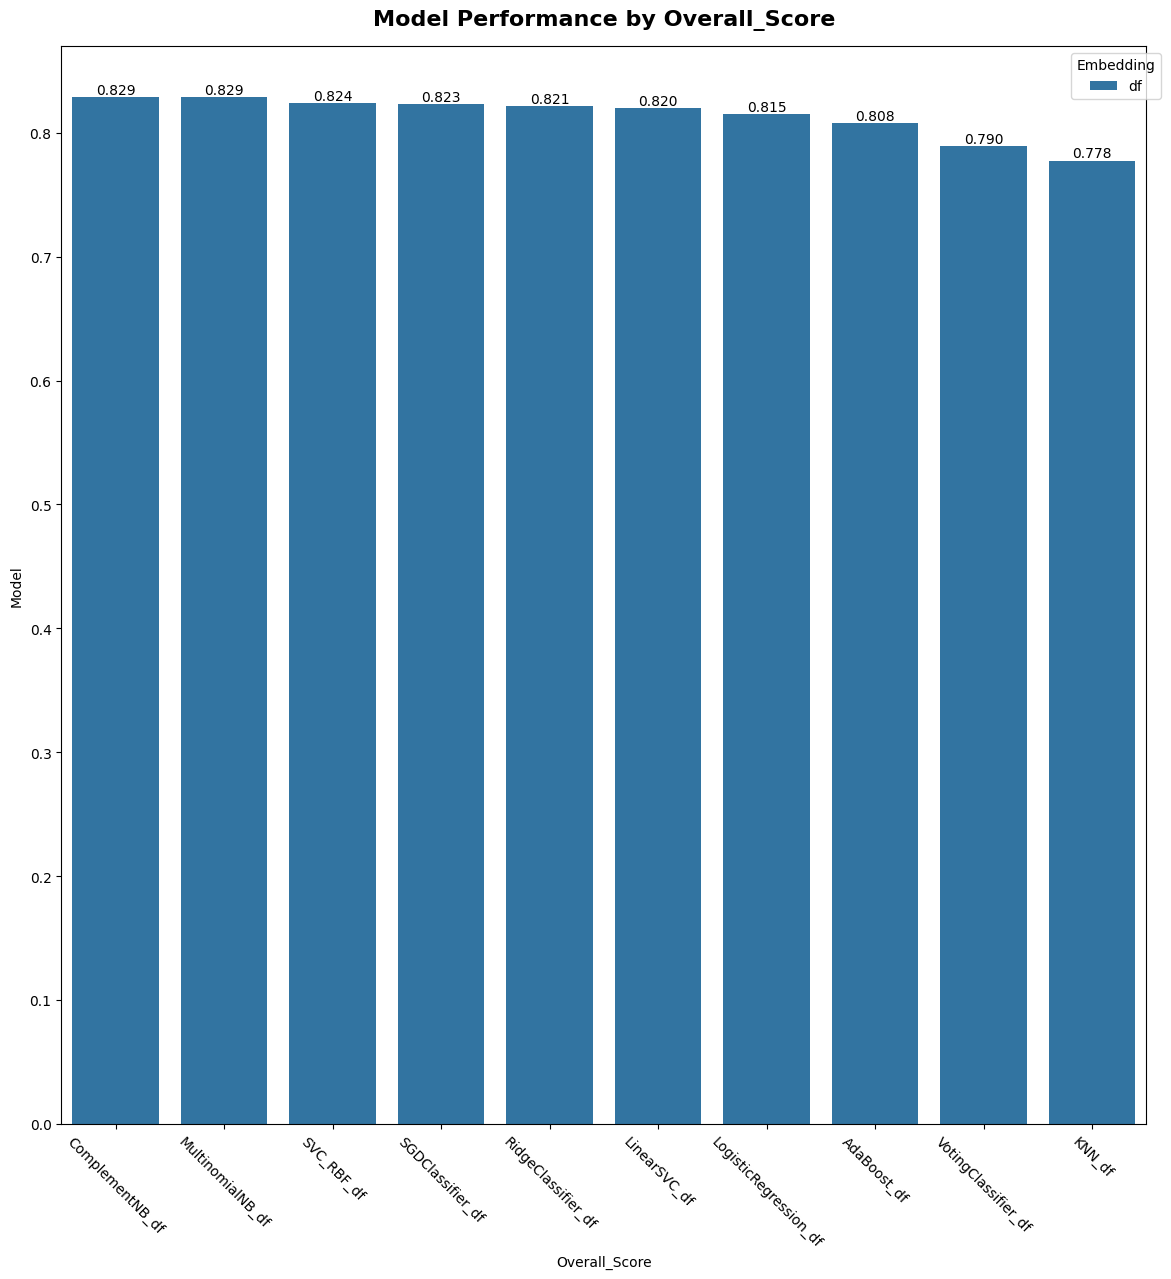

In [40]:
plot_model_performance(best_models, metric="Overall_Score", save_fig_path="../results/figures/model_performance_by_overall_score.png")

In [41]:
combined_models = combine_model_dicts(existing_models, existing_models_suffixes)
save_pickle(combined_models, join_paths(MODELS_SAVE_DIR, "combined_models.pkl"))
combined_models.keys()

dict_keys(['LogisticRegression_df', 'SGDClassifier_df', 'RidgeClassifier_df', 'PassiveAggressive_df', 'LinearSVC_df', 'SVC_RBF_df', 'MultinomialNB_df', 'ComplementNB_df', 'BernoulliNB_df', 'DecisionTree_df', 'RandomForest_df', 'ExtraTrees_df', 'AdaBoost_df', 'GradientBoosting_df', 'Bagging(KNN)_df', 'MLP_df', 'KNN_df', 'StackingClassifier_df', 'VotingClassifier_df'])